In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.model_selection import KFold
import numpy as np
from tqdm import tqdm
import psutil
import os
#os.environ['CUDA_LAUNCH_BLOCKING']="1"
#os.environ['TORCH_USE_CUDA_DSA'] = "1"

class RedditAuthorshipDataset(Dataset):
    def __init__(self, texts, authors, tokenizer, max_length=128):
        self.texts = texts
        self.authors = authors
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text1, author1 = self.texts[idx], self.authors[idx]
        # Randomly select another sample
        other_idx = np.random.randint(len(self.texts))
        text2, author2 = self.texts[other_idx], self.authors[other_idx]
        
        label = 1 if author1 == author2 else 0

        encoding1 = self.tokenizer.encode_plus(
            text1,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        encoding2 = self.tokenizer.encode_plus(
            text2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids1': encoding1['input_ids'].flatten(),
            'attention_mask1': encoding1['attention_mask'].flatten(),
            'input_ids2': encoding2['input_ids'].flatten(),
            'attention_mask2': encoding2['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class ContrastiveAuthorshipModel(nn.Module):
    def __init__(self, pretrained_model_name='roberta-base'):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_name)
        self.projection = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        output1 = self.roberta(input_ids1, attention_mask=attention_mask1)
        output2 = self.roberta(input_ids2, attention_mask=attention_mask2)
        
        embedding1 = self.projection(self.dropout(output1.last_hidden_state[:, 0, :]))
        embedding2 = self.projection(self.dropout(output2.last_hidden_state[:, 0, :]))
        
        return embedding1, embedding2


def contrastive_loss(embedding1, embedding2, label, temperature=1):
    cosine_similarity = nn.functional.cosine_similarity(embedding1, embedding2)
    similarity_scaled = cosine_similarity / temperature
    loss = torch.mean((1 - label) * torch.pow(torch.clamp(similarity_scaled, min=0.0), 2) +
                      label * torch.pow(1 - similarity_scaled, 2))
    return loss

def train(model, train_loader, val_loader, optimizer, device, epochs=5, patience=3):
    model.train()
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    for epoch in range(epochs):
        start_memory = get_memory_usage()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            embedding1, embedding2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            loss = contrastive_loss(embedding1, embedding2, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        end_memory = get_memory_usage()
        print(f"Memory Usage: {end_memory - start_memory:.2f} MB")
        
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}")
        
        # Validation step
        val_loss, val_accuracy = evaluate(model, val_loader, device)
        print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_authorship_model.pth')
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after epoch {epoch+1}")
                break
    
    return model

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids1 = batch['input_ids1'].to(device)
            attention_mask1 = batch['attention_mask1'].to(device)
            input_ids2 = batch['input_ids2'].to(device)
            attention_mask2 = batch['attention_mask2'].to(device)
            labels = batch['label'].to(device)

            embedding1, embedding2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
            loss = contrastive_loss(embedding1, embedding2, labels)
            total_loss += loss.item()

            similarity = nn.functional.cosine_similarity(embedding1, embedding2)
            predictions = (similarity > 0.5).long()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def predict_authorship(model, tokenizer, text1, text2, device, threshold=0.5):
    model.eval()
    encoding1 = tokenizer.encode_plus(
        text1,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoding2 = tokenizer.encode_plus(
        text2,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids1 = encoding1['input_ids'].to(device)
    attention_mask1 = encoding1['attention_mask'].to(device)
    input_ids2 = encoding2['input_ids'].to(device)
    attention_mask2 = encoding2['attention_mask'].to(device)
    
    with torch.no_grad():
        embedding1, embedding2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        similarity = nn.functional.cosine_similarity(embedding1, embedding2).item()
    
    same_author = similarity > threshold
    return same_author, similarity

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)  # in MB

def estimate_memory_usage(model, batch_size, seq_length, dtype=torch.float32):
    def numel(model):
        return sum(p.numel() for p in model.parameters())

    # Model parameters
    model_params_memory = numel(model) * dtype.itemsize

    # Estimate memory for one forward + backward pass
    input_size = batch_size * seq_length
    activations_memory = input_size * model.roberta.config.hidden_size * dtype.itemsize * 2  # *2 for forward and backward
    gradients_memory = model_params_memory
    
    # Optimizer memory (assuming Adam)
    optimizer_memory = model_params_memory * 2  # Adam keeps two additional values per parameter

    # Estimate memory for embeddings
    embedding_memory = batch_size * 2 * seq_length * model.roberta.config.hidden_size * dtype.itemsize

    # Estimate memory for attention masks
    attention_mask_memory = batch_size * 2 * seq_length * torch.bool.itemsize

    # Total estimated memory
    total_memory = (model_params_memory + activations_memory + gradients_memory + 
                    optimizer_memory + embedding_memory + attention_mask_memory)

    # Convert to MB
    total_memory_mb = total_memory / (1024 * 1024)

    return total_memory_mb

### Main
# Load Reddit dataset
data = load_dataset("reddit", split="train[:10000]", trust_remote_code=True)
texts = data['content']
authors = data['author']

import gc
torch.cuda.empty_cache()
gc.collect()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(f"Using device: {device}")

# Parameters
batch_size = 32
seq_length = 128  # Max sequence length

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
dataset = RedditAuthorshipDataset(texts, authors, tokenizer)

model = ContrastiveAuthorshipModel().to(device)
#model.load_state_dict(torch.load('best_authorship_model.pth'))

# Estimate memory usage
estimated_memory = estimate_memory_usage(model, batch_size, seq_length)
print(f"Estimated memory usage per batch: {estimated_memory:.2f} MB")

# Estimate for entire dataset
dataset_size = 10000  # Adjust this to your actual dataset size
num_batches = dataset_size // batch_size
total_estimated_memory = estimated_memory * num_batches
print(f"Estimated total memory usage for one epoch: {total_estimated_memory:.2f} MB")


# K-Fold Cross-Validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset), 1):
    print(f"Fold {fold}/{n_splits}")

    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    train_loader = DataLoader(dataset, batch_size=32, sampler=train_subsampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_subsampler)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

    model = train(model, train_loader, val_loader, optimizer, device, epochs=2, patience=1)

# Load the best model for prediction
best_model = ContrastiveAuthorshipModel().to(device)
best_model.load_state_dict(torch.load('best_authorship_model.pth'))

# Example prediction
text1 = """There were no Dark Ages! They didn't happen! Byzantium was happily being Byzantium. The Muslims were doing fucking amazing things! Al-Andalus was a beacon of cultural integration, art, science, and philosophy! Ibn Khaldun was inventing modern history! 
        The 'Dark Ages' where when a bunch of dirt sucking savages from east-bumfuck lost contact with the First World, which is to say the Mediterranean. It was 'Dark' because no one who mattered gave two shits what was happening in Germania because Germania was utterly irrelevant to the world economy, sciences, history, and politics. Europe went through the 'Dark Ages' because Europe was not important. It was a worthless, cold, savage back water full of dirty hairy people who wore pants. 
        Right up until 700ish, when the Scandanavians went a viking and started to spread their culture across Northern Europe, setting up trade across the continent, forcing other NE cultures to centralize and become more efficient to resist the north men. 
        Seriously, though, the Muslims were rocking out with their Qu'ran out after about 600, and they did more for art, science, philosophy, and poetry than the Romans had done since 100ad. The period of Muslim ascendancy flowed smoothly out of the fall of Western Rome and then snugged seamlessly into the Renaissance. 
        And then the Norse were doing all sorts of wacky stuff with democracy and law from the mid millenium. Really, if there was a 'Dark Age' it was only from about 450, when the Romans abandoned Italy, to abou 600, when the Muslims really started kicking ass and taking names. 
        The only thing that was really 'lost' with the fall of Western Rome was the extremely powerful and centralized Roman state. All the cool technology they had persisted in other places (Specifically, everywhere except Europe), but without the massive centralization that let the Romans make use of it on such a large scale."""
text2 = """I would associate the decline of the church largely to the loss of power of the Roman Empire in germania and western Europe, which was due to a large number of complicated factors, including over extension of the Empire's resources, migration of 'barbarian' peoples into the empire, the conflict between Pagan Roman religion and Christianity (Fun fact, the Visigoths that sacked Rome were Arian Christians, followers of a creed that had been declared heretical at the council of Nicea), and many, many other things. The Roman Empire was extremely important to pre-medieval Europe, introducing all kinds of culture and technology. When the financial and military support of the Empire withdrew much of that culture and technology went with it. 
        Also, I would like to note that up until... hmm, probably the 1500s or 1600s many, many powerful political figures were members were both Clergy and princes. Many Bishops and other church figures held land, raised armies, went to war, and participated in the councils of kings. They fought with secular lords and also with each other. 
        I would not say that the Church caused any decline in Europe, on the grounds that in many way there is no Europe without the Church and their is no Church without Europe. Catholicism was the culture of Europe from around 500 to around 1700. The Church was as important and basic a component of culture at that time as the Internet is now. Priests were often the only people with a semblance of education, the only people able to write and receive letters. While some theologians certainly advocated a radical and oppressive form of Christianity, others provided council to their leaders that served to limit the gross abuses of Feudalism. 
        In the end it's far too complicated to say that the Christian Church was a good thing or a bad thing. It spurred Europe to destructive wars with the Muslims to the south and the pagan Slavs in the east. It provided the foundations for rational inquiry on which Science was founded. It founded and promulgated the Inquisition, which was both a machine of torture and oppression and an instrument of social and political justice. The church preserved knowledge from the time of Rome and suppressed new knowledge. The church contributed and obstructed philosophy. 
        If Catholicism hadn't become the dominant religion in Europe I don't know that things would have changed very much. Certainly a Europe that followed the Mithras cult or kept to Roman or Germanic Paganism would be different, but I don't think humanity would necessarily have made more social or technical progress. The Romans could be as brutal and sadistic as any Inquistor, and the Vikings were notorious for being savage in battle. The Muslims put whole cities to the sword, and the Mongols carved a swath across the entire world. If Roman Catholicism hadn't risen to become the dominant cultural framework of Europe then it seems likely to me that one of those four groups, the Muslims, the Norsemen, the Romans, or the Mongols, would have shaped the face of Europe. Each culture had its great triumphs and terrible deeds."""
same_author, similarity = predict_authorship(best_model, tokenizer, text1, text2, device)
print(f"Texts are by the same author: {same_author}")
print(f"Similarity score: {similarity:.4f}")


c:\Users\mcant\OneDrive\Documents\GitHub\Shared-Specific-Distinctive-Tendencies\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


c:\Users\mcant\OneDrive\Documents\GitHub\Shared-Specific-Distinctive-Tendencies\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Estimated memory usage per batch: 1953.46 MB
Estimated total memory usage for one epoch: 609477.98 MB
Fold 1/2


Epoch 1/2: 100%|██████████| 157/157 [38:58<00:00, 14.90s/it]


Memory Usage: 1414.74 MB
Epoch 1/2, Train Loss: 0.0715


Evaluating: 100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Validation - Loss: 0.0283, Accuracy: 0.9908


Epoch 2/2: 100%|██████████| 157/157 [20:59<00:00,  8.02s/it]


Memory Usage: -798.73 MB
Epoch 2/2, Train Loss: 0.0158


Evaluating: 100%|██████████| 157/157 [02:07<00:00,  1.23it/s]


Validation - Loss: 0.0135, Accuracy: 0.9974
Fold 2/2


Epoch 1/2: 100%|██████████| 157/157 [39:49<00:00, 15.22s/it]


Memory Usage: -1099.51 MB
Epoch 1/2, Train Loss: 0.0114


Evaluating: 100%|██████████| 157/157 [02:00<00:00,  1.30it/s]


Validation - Loss: 0.0176, Accuracy: 0.9946


Epoch 2/2: 100%|██████████| 157/157 [21:40<00:00,  8.29s/it]


Memory Usage: -16.70 MB
Epoch 2/2, Train Loss: 0.0128


Evaluating: 100%|██████████| 157/157 [02:03<00:00,  1.27it/s]


Validation - Loss: 0.0122, Accuracy: 0.9980


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mcant\AppData\Local\Temp\ipykernel_38180\1776905214.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

Texts are by the same author: True
Similarity score: 0.5149


Using device: cuda


c:\Users\mcant\OneDrive\Documents\GitHub\Shared-Specific-Distinctive-Tendencies\venv\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\mcant\AppData\Local\Temp\ipykernel_32404\605277445.py:175: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pick

100
e:  1
e:  2
e:  3
e:  4
t:  1
e:  1
e:  2
e:  3
e:  4
e:  5
t:  2
e:  1
e:  2
t:  3
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
e:  14
e:  15
t:  4
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
t:  5
e:  1
e:  2
e:  3
t:  6
e:  1
e:  2
e:  3
e:  4
e:  5
t:  7
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
t:  8
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
e:  14
e:  15
e:  16
t:  9
e:  1
t:  10
e:  1
e:  2
t:  11
e:  1
t:  12
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
t:  13
e:  1
e:  2
t:  14
e:  1
e:  2
e:  3
e:  4
t:  15
e:  1
t:  16
e:  1
e:  2
e:  3
e:  4
e:  5
t:  17
e:  1
t:  18
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
t:  19
e:  1
e:  2
t:  20
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
t:  21
e:  1
t:  22
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
e:  14
e:  15
e:  16
e:  17
t:  23
e:  1
e:  2
e

Computing similarities: 100%|██████████| 200/200 [00:05<00:00, 36.04it/s]


Validating threshold: 0.01
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.03
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.049999999999999996
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.06999999999999999
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.08999999999999998
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.10999999999999997
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.12999999999999998
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.15
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.16999999999999998
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.18999999999999997
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.20999999999999996
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating threshold: 0.22999999999999998
Accuracy: 0.5, F1 Score: 0.6666666666666666
Validating t

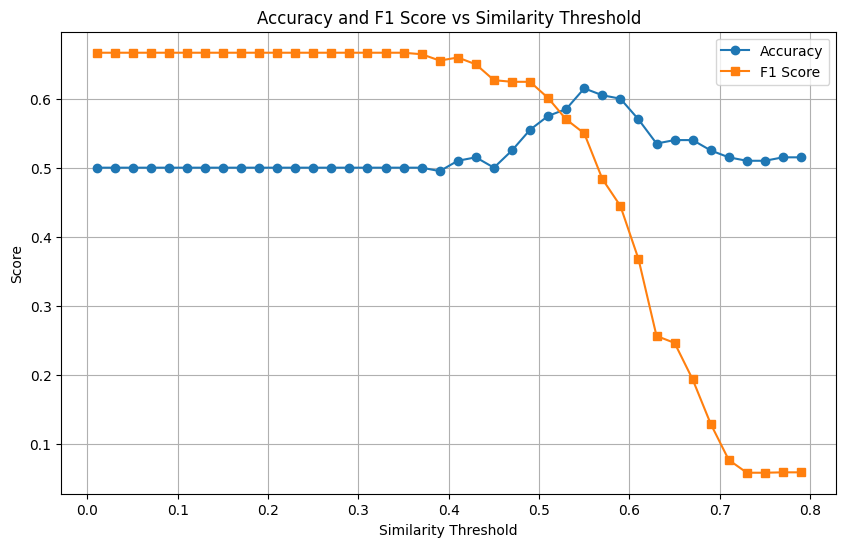

Best threshold: 0.01
Best F1 Score: 0.6666666666666666


In [6]:
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import Dataset, DataLoader
import psutil

class ContrastiveAuthorshipModel(nn.Module):
    def __init__(self, pretrained_model_name='roberta-base', freeze_base=False):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_name)
        
        if freeze_base:
            for param in self.roberta.parameters():
                param.requires_grad = False
        
        self.projection = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128)
        )
        
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output.last_hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2):
        output1 = self.roberta(input_ids1, attention_mask=attention_mask1)
        output2 = self.roberta(input_ids2, attention_mask=attention_mask2)
        
        pooled_output1 = self.mean_pooling(output1, attention_mask1)
        pooled_output2 = self.mean_pooling(output2, attention_mask2)
        
        embedding1 = self.projection(pooled_output1)
        embedding2 = self.projection(pooled_output2)
        
        return embedding1, embedding2

def get_embedding(model, text):
    return model.encode(text)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def model_similarity(model, a, b):
    return model.similarity(a, b)

def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
    return e_x / e_x.sum()

#def create_pairs(texts, authors, n_pairs):
#    pairs = []
#    labels = []
#    for _ in range(n_pairs):
#        idx1, idx2 = np.random.choice(len(texts), 2, replace=False)
#        pairs.append((texts[idx1], texts[idx2]))
#        labels.append(int(authors[idx1] == authors[idx2]))
#    return pairs, labels

def create_pairs(texts, authors, n_pairs):
    pairs = []
    labels = []
    unique_authors = list(set(authors))
    e = 0
    t = 0
    
    # Create positive pairs (same author)
    n_positive = n_pairs // 2
    print(n_positive)
    while t < n_positive and e < 50:
        author = np.random.choice(unique_authors)
        author_texts = [text for text, a in zip(texts, authors) if a == author]
        if len(author_texts) < 2:
            e+=1
            print("e: ", e)
            continue
        text1, text2 = np.random.choice(author_texts, 2, replace=False)
        pairs.append((text1, text2))
        labels.append(1)
        t+=1
        print("t: ", t)
        e=0
    
    # Create negative pairs (different authors)
    n_negative = n_pairs - len(pairs)
    for _ in range(n_negative):
        author1, author2 = np.random.choice(unique_authors, 2, replace=False)
        text1 = np.random.choice([text for text, a in zip(texts, authors) if a == author1])
        text2 = np.random.choice([text for text, a in zip(texts, authors) if a == author2])
        pairs.append((text1, text2))
        labels.append(0)
    
    return pairs, labels

def predict_authorship(model, tokenizer, text1, text2, device):
    model.eval()
    encoding1 = tokenizer.encode_plus(
        text1,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoding2 = tokenizer.encode_plus(
        text2,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids1 = encoding1['input_ids'].to(device)
    attention_mask1 = encoding1['attention_mask'].to(device)
    input_ids2 = encoding2['input_ids'].to(device)
    attention_mask2 = encoding2['attention_mask'].to(device)
    
    with torch.no_grad():
        embedding1, embedding2 = model(input_ids1, attention_mask1, input_ids2, attention_mask2)
        similarity = nn.functional.cosine_similarity(embedding1, embedding2).item()
    
    return similarity

def validate_similarities(model, tokenizer, pairs, device):
    similarities = []
    for text1, text2 in tqdm(pairs, desc="Computing similarities"):
        similarity = predict_authorship(model, tokenizer, text1, text2, device)
        centered_similarity = 0.5 * (similarity + 1)
        #similarity = model_similarity(model, emb1, emb2)
        similarities.append(centered_similarity)
    #softsims = softmax(similarities)
    return similarities

def validate_threshold(labels, threshold, similarities):
    predictions = [int(sim > threshold) for sim in similarities]
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return accuracy, f1

def main():
    # Load Reddit dataset
    data = load_dataset("reddit", split="train[10000:100000]", trust_remote_code=True)
    texts = data['content']
    authors = data['author']

    import gc
    torch.cuda.empty_cache()
    gc.collect()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = torch.device('cpu')
    print(f"Using device: {device}")

    #load tokenizer
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    #Load embedding model
    #model = SentenceTransformer("all-mpnet-base-v2")
    model = ContrastiveAuthorshipModel().to(device)
    model.load_state_dict(torch.load('best_authorship_model.pth'))

    # Create pairs for validation
    pairs, labels = create_pairs(texts, authors, n_pairs=200)

    # Validate thresholds
    thresholds = np.arange(0.01, 0.8, 0.02)
    accuracies = []
    f1_scores = []

    similarities = validate_similarities(model, tokenizer, pairs, device)
    for threshold in thresholds:
        print(f"Validating threshold: {threshold}")
        accuracy, f1 = validate_threshold(labels, threshold, similarities)
        accuracies.append(accuracy)
        f1_scores.append(f1)
        print(f"Accuracy: {accuracy}, F1 Score: {f1}")

    # Visualize results
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, label='Accuracy', marker='o')
    plt.plot(thresholds, f1_scores, label='F1 Score', marker='s')
    plt.xlabel('Similarity Threshold')
    plt.ylabel('Score')
    plt.title('Accuracy and F1 Score vs Similarity Threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig('validation_results.png')
    plt.show()

    # Find best threshold
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold: {best_threshold}")
    print(f"Best F1 Score: {max(f1_scores)}")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import numpy as np

class HybridAuthorshipModel(nn.Module):
    def __init__(self, pretrained_model_name='distilbert-base-uncased', ngram_range=(1, 3), max_features=5000):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained(pretrained_model_name)
        self.projection = nn.Linear(self.distilbert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        
        # N-gram vectorizer
        self.ngram_vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
        
        # Combine embeddings and n-gram features
        self.combine_layer = nn.Linear(128 + max_features, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, ngram_features1, ngram_features2):
        # Process through DistilBERT
        output1 = self.distilbert(input_ids1, attention_mask=attention_mask1)
        output2 = self.distilbert(input_ids2, attention_mask=attention_mask2)
        
        # Get embeddings
        embedding1 = self.projection(self.dropout(output1.last_hidden_state[:, 0, :]))
        embedding2 = self.projection(self.dropout(output2.last_hidden_state[:, 0, :]))
        
        # Combine with n-gram features
        combined1 = torch.cat([embedding1, ngram_features1], dim=1)
        combined2 = torch.cat([embedding2, ngram_features2], dim=1)
        
        # Process through combination layers
        processed1 = self.combine_layer(combined1)
        processed2 = self.combine_layer(combined2)
        
        # Compute similarity
        similarity = torch.cosine_similarity(processed1, processed2)
        
        return similarity

def prepare_ngram_features(texts, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=5000)
        vectorizer.fit(texts)
    
    features = vectorizer.transform(texts).toarray()
    features_normalized = normalize(features, norm='l2', axis=1)
    return torch.FloatTensor(features_normalized), vectorizer

def contrastive_loss(similarity, label, margin=1.0):
    loss_same = label * torch.pow(1 - similarity, 2)
    loss_diff = (1 - label) * torch.pow(torch.clamp(similarity - margin, min=0.0), 2)
    return (loss_same + loss_diff).mean()

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        ngram_features1 = batch['ngram_features1'].to(device)
        ngram_features2 = batch['ngram_features2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        similarity = model(input_ids1, attention_mask1, input_ids2, attention_mask2, ngram_features1, ngram_features2)
        loss = contrastive_loss(similarity, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

# Example usage
def main():
    # Load your dataset
    texts, authors = load_dataset()  # Implement this function to load your data
    
    # Prepare n-gram features
    ngram_features, vectorizer = prepare_ngram_features(texts)
    
    # Create dataset and data loader (you'll need to implement these)
    train_loader = create_data_loader(texts, authors, ngram_features)
    
    # Initialize model and optimizer
    model = HybridAuthorshipModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    
    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

    # Save the model
    torch.save(model.state_dict(), 'hybrid_authorship_model.pth')

if __name__ == "__main__":
    main()

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from datasets import load_dataset
import numpy as np
from tqdm import tqdm

class HybridAuthorshipModel(nn.Module):
    def __init__(self, pretrained_model_name='distilbert-base-uncased', ngram_range=(1, 3), max_features=5000):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained(pretrained_model_name)
        self.projection = nn.Linear(self.distilbert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        
        # N-gram vectorizer
        self.ngram_vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
        
        # Combine embeddings and n-gram features
        self.combine_layer = nn.Linear(128 + max_features, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, ngram_features1, ngram_features2):
        # Process through DistilBERT
        output1 = self.distilbert(input_ids1, attention_mask=attention_mask1)
        output2 = self.distilbert(input_ids2, attention_mask=attention_mask2)
        
        # Get embeddings
        embedding1 = self.projection(self.dropout(output1.last_hidden_state[:, 0, :]))
        embedding2 = self.projection(self.dropout(output2.last_hidden_state[:, 0, :]))
        
        # Combine with n-gram features
        combined1 = torch.cat([embedding1, ngram_features1], dim=1)
        combined2 = torch.cat([embedding2, ngram_features2], dim=1)
        
        # Process through combination layers
        processed1 = self.combine_layer(combined1)
        processed2 = self.combine_layer(combined2)
        
        # Compute similarity
        similarity = torch.cosine_similarity(processed1, processed2)
        
        return similarity

def prepare_ngram_features(texts, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=5000)
        vectorizer.fit(texts)
    
    features = vectorizer.transform(texts).toarray()
    features_normalized = normalize(features, norm='l2', axis=1)
    return torch.FloatTensor(features_normalized), vectorizer

def contrastive_loss(similarity, label):
    loss_same = label * torch.pow(1 - similarity, 2)
    loss_diff = (1 - label) * torch.pow(torch.clamp(similarity, min=0.0), 2)
    return (loss_same + loss_diff).mean()

class RedditAuthorshipDataset(Dataset):
    def __init__(self, texts, authors, ngram_features, tokenizer, max_length=128):
        self.texts = texts
        self.authors = authors
        self.ngram_features = ngram_features
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text1, author1 = self.texts[idx], self.authors[idx]
        other_idx = np.random.randint(len(self.texts))
        text2, author2 = self.texts[other_idx], self.authors[other_idx]
        
        label = 1 if author1 == author2 else 0

        encoding1 = self.tokenizer.encode_plus(
            text1,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        encoding2 = self.tokenizer.encode_plus(
            text2,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids1': encoding1['input_ids'].flatten(),
            'attention_mask1': encoding1['attention_mask'].flatten(),
            'input_ids2': encoding2['input_ids'].flatten(),
            'attention_mask2': encoding2['attention_mask'].flatten(),
            'ngram_features1': self.ngram_features[idx],
            'ngram_features2': self.ngram_features[other_idx],
            'label': torch.tensor(label, dtype=torch.float)
        }

def pull_dataset(num_samples=10000):
    # Load Reddit dataset
    data = load_dataset("reddit", split=f"train[:{num_samples}]", trust_remote_code=True)
    texts = data['content']
    authors = data['author']
    return texts, authors

def create_data_loader(texts, authors, ngram_features, tokenizer, batch_size=32):
    dataset = RedditAuthorshipDataset(texts, authors, ngram_features, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        ngram_features1 = batch['ngram_features1'].to(device)
        ngram_features2 = batch['ngram_features2'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        similarity = model(input_ids1, attention_mask1, input_ids2, attention_mask2, ngram_features1, ngram_features2)
        loss = contrastive_loss(similarity, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load dataset
    texts, authors = pull_dataset(num_samples=10000)  # Adjust number of samples as needed
    
    # Prepare n-gram features
    ngram_features, vectorizer = prepare_ngram_features(texts)
    
    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    
    # Create data loader
    train_loader = create_data_loader(texts, authors, ngram_features, tokenizer)
    
    # Initialize model and optimizer
    model = HybridAuthorshipModel().to(device)
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    # Training loop
    num_epochs = 5
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

    # Save the model
    torch.save(model.state_dict(), 'hybrid_authorship_model.pth')

if __name__ == "__main__":
    main()

Using device: cuda


c:\Users\mcant\OneDrive\Documents\GitHub\Shared-Specific-Distinctive-Tendencies\venv\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mcant\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\Users\mcant\OneDrive\Documents\GitHub\Shared-Specific-

Epoch 1/5, Loss: 0.0209


Training: 100%|██████████| 313/313 [05:37<00:00,  1.08s/it]


Epoch 2/5, Loss: 0.0131


Training: 100%|██████████| 313/313 [05:52<00:00,  1.13s/it]


Epoch 3/5, Loss: 0.0123


Training: 100%|██████████| 313/313 [06:01<00:00,  1.15s/it]


Epoch 4/5, Loss: 0.0115


Training: 100%|██████████| 313/313 [06:08<00:00,  1.18s/it]


Epoch 5/5, Loss: 0.0108


Using device: cuda


C:\Users\mcant\AppData\Local\Temp\ipykernel_12216\3959097183.py:98: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=d

50
t:  1
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
t:  2
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
e:  14
e:  15
e:  16
e:  17
e:  18
e:  19
e:  20
e:  21
e:  22
t:  3
e:  1
e:  2
e:  3
e:  4
t:  4
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
e:  14
e:  15
e:  16
e:  17
e:  18
e:  19
e:  20
e:  21
e:  22
e:  23
e:  24
e:  25
e:  26
e:  27
e:  28
e:  29
e:  30
e:  31
e:  32
e:  33
e:  34
e:  35
e:  36
e:  37
e:  38
e:  39
e:  40
e:  41
e:  42
e:  43
e:  44
e:  45
t:  5
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
t:  6
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  8
e:  9
e:  10
e:  11
e:  12
e:  13
e:  14
e:  15
e:  16
e:  17
e:  18
e:  19
e:  20
e:  21
e:  22
e:  23
e:  24
e:  25
e:  26
e:  27
e:  28
e:  29
e:  30
e:  31
e:  32
e:  33
e:  34
e:  35
e:  36
e:  37
e:  38
e:  39
e:  40
e:  41
t:  7
t:  8
e:  1
e:  2
e:  3
e:  4
e:  5
e:  6
e:  7
e:  

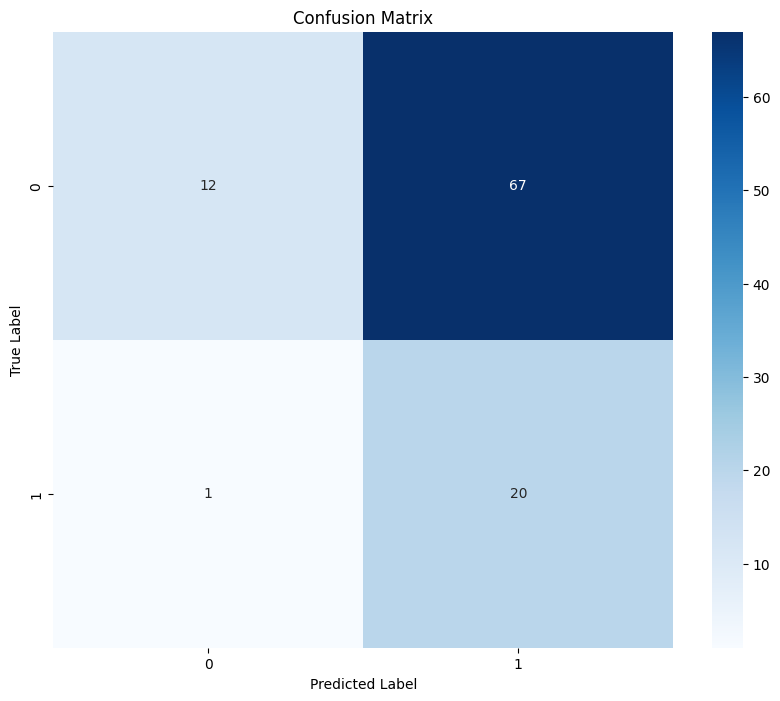

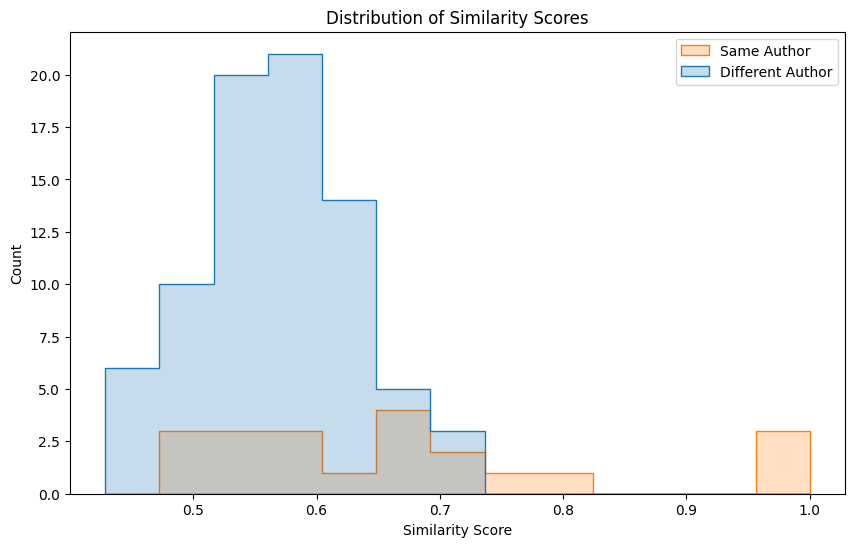


Error Analysis:

Error 18:
Text 1: I'm sorry to say that if she doesn't clean up to your satisfaction you have the choices of cleaning ...
Text 2: We may never know. There is no evidence at this time to lead me to  any  conclusions. If there's no ...
Actually same author: 1
Predicted same author: False
Similarity score: 0.4764

Error 23:
Text 1: I love that...
Text 2: Once my friend who was playing as the US (I was the Soviets, allied with the US and England) forgot ...
Actually same author: 0
Predicted same author: True
Similarity score: 0.5050

Error 24:
Text 1: easy, but you  will need patience, even if the group is 555+ there are usually plenty of 570+ lining...
Text 2: Wall of text, here's a few gimmicks I've learned to help tons: 
 Reduced damage from elites is the m...
Actually same author: 0
Predicted same author: True
Similarity score: 0.6937

Error 25:
Text 1: Off the top of my head I can think of... 
 -The loyalty reward glitch 
 -Nisha's broken classmod (fi...
Text 2: Agre

In [7]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from datasets import load_dataset
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

class HybridAuthorshipModel(nn.Module):
    def __init__(self, pretrained_model_name='distilbert-base-uncased', ngram_range=(1, 3), max_features=5000):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained(pretrained_model_name)
        self.projection = nn.Linear(self.distilbert.config.hidden_size, 128)
        self.dropout = nn.Dropout(0.1)
        
        # N-gram vectorizer
        self.ngram_vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=max_features)
        
        # Combine embeddings and n-gram features
        self.combine_layer = nn.Linear(128 + max_features, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, input_ids1, attention_mask1, input_ids2, attention_mask2, ngram_features1, ngram_features2):
        # Process through DistilBERT
        output1 = self.distilbert(input_ids1, attention_mask=attention_mask1)
        output2 = self.distilbert(input_ids2, attention_mask=attention_mask2)
        
        # Get embeddings
        embedding1 = self.projection(self.dropout(output1.last_hidden_state[:, 0, :]))
        embedding2 = self.projection(self.dropout(output2.last_hidden_state[:, 0, :]))
        
        # Combine with n-gram features
        combined1 = torch.cat([embedding1, ngram_features1], dim=1)
        combined2 = torch.cat([embedding2, ngram_features2], dim=1)
        
        # Process through combination layers
        processed1 = self.combine_layer(combined1)
        processed2 = self.combine_layer(combined2)
        
        # Compute similarity
        similarity = torch.cosine_similarity(processed1, processed2)
        
        return similarity

def prepare_ngram_features(texts, vectorizer):
    features = vectorizer.transform(texts).toarray()
    features_normalized = normalize(features, norm='l2', axis=1)
    return torch.FloatTensor(features_normalized)

def predict_authorship(model, tokenizer, vectorizer, text1, text2, device, threshold=0.5):
    model.eval()
    
    # Tokenize inputs
    encoding1 = tokenizer.encode_plus(
        text1,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoding2 = tokenizer.encode_plus(
        text2,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Prepare n-gram features
    ngram_features = prepare_ngram_features([text1, text2], vectorizer)
    
    # Move inputs to device
    input_ids1 = encoding1['input_ids'].to(device)
    attention_mask1 = encoding1['attention_mask'].to(device)
    input_ids2 = encoding2['input_ids'].to(device)
    attention_mask2 = encoding2['attention_mask'].to(device)
    ngram_features1 = ngram_features[0].unsqueeze(0).to(device)
    ngram_features2 = ngram_features[1].unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        similarity = model(input_ids1, attention_mask1, input_ids2, attention_mask2, ngram_features1, ngram_features2)
    
    similarity_score = similarity.item()
    similarity_score = 0.5 * (similarity_score + 1) #centered_similarity
    same_author = similarity_score > threshold
    
    return same_author, similarity_score

def load_model(model_path, device):
    model = HybridAuthorshipModel()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def load_reddit_data(num_samples=20000):
    dataset = load_dataset("reddit", split=f"train[:{num_samples}]", trust_remote_code=True)
    return dataset['content'], dataset['author']

#def create_test_pairs(texts, authors, num_pairs=100):
#    author_to_texts = {}
#    for text, author in zip(texts, authors):
#        if author not in author_to_texts:
#            author_to_texts[author] = []
#        author_to_texts[author].append(text)
#    
#    same_author_pairs = []
#    different_author_pairs = []
#    
#    # Create same author pairs
#    for author, author_texts in author_to_texts.items():
#        if len(author_texts) >= 2:
#            pair = random.sample(author_texts, 2)
#            same_author_pairs.append((pair[0], pair[1], True))
#    
#    # Create different author pairs
#    authors_list = list(author_to_texts.keys())
#    for _ in range(num_pairs - len(same_author_pairs)):
#        author1, author2 = random.sample(authors_list, 2)
#        text1 = random.choice(author_to_texts[author1])
#        text2 = random.choice(author_to_texts[author2])
#        different_author_pairs.append((text1, text2, False))
#    
#    # Combine and shuffle
#    all_pairs = same_author_pairs + different_author_pairs
#    random.shuffle(all_pairs)
#    
#    return all_pairs[:num_pairs]

def create_test_pairs(texts, authors, n_pairs=100):
    pairs = []
    labels = []
    unique_authors = list(set(authors))
    e = 0
    t = 0
    
    # Create positive pairs (same author)
    n_positive = n_pairs // 2
    print(n_positive)
    while t < n_positive and e < 50:
        author = np.random.choice(unique_authors)
        author_texts = [text for text, a in zip(texts, authors) if a == author]
        if len(author_texts) < 2:
            e+=1
            print("e: ", e)
            continue
        text1, text2 = np.random.choice(author_texts, 2, replace=False)
        pairs.append((text1, text2))
        labels.append(1)
        t+=1
        print("t: ", t)
        e=0
    
    # Create negative pairs (different authors)
    n_negative = n_pairs - len(pairs)
    for _ in range(n_negative):
        author1, author2 = np.random.choice(unique_authors, 2, replace=False)
        text1 = np.random.choice([text for text, a in zip(texts, authors) if a == author1])
        text2 = np.random.choice([text for text, a in zip(texts, authors) if a == author2])
        pairs.append((text1, text2))
        labels.append(0)
    
    all_pairs = [(p[0], p[1], l) for p, l in zip(pairs, labels)]
    
    return all_pairs

def evaluate_model(model, tokenizer, vectorizer, test_pairs, device):
    y_true = []
    y_pred = []
    similarities = []
    errors = []

    for i, (text1, text2, is_same_author) in enumerate(test_pairs):
        same_author_pred, similarity = predict_authorship(model, tokenizer, vectorizer, text1, text2, device)
        y_true.append(int(is_same_author))
        y_pred.append(int(same_author_pred))
        #similarity = 0.5 * (similarity + 1) #centered_similarity
        similarities.append(similarity)

        if int(is_same_author) != int(same_author_pred):
            errors.append((i, text1, text2, is_same_author, same_author_pred, similarity))

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred, target_names=['Different Author', 'Same Author'])

    return accuracy, f1, conf_matrix, class_report, errors, similarities

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def plot_similarity_distribution(similarities, y_true):
    plt.figure(figsize=(10, 6))
    sns.histplot(x=similarities, hue=y_true, kde=False, element="step", legend=True)
    plt.title('Distribution of Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Count')
    plt.legend(['Same Author', 'Different Author'])
    plt.show()

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Load the trained model
    model_path = 'hybrid_authorship_model.pth'
    model = load_model(model_path, device)

    # Initialize tokenizer and vectorizer
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    vectorizer = CountVectorizer(ngram_range=(1, 3), max_features=5000)
    
    # Load Reddit data
    texts, authors = load_reddit_data()
    
    # Fit vectorizer on a sample of texts
    sample_texts = random.sample(texts, 1000)  # Use 1000 random texts to fit vectorizer
    vectorizer.fit(sample_texts)
    
    # Create test pairs
    test_pairs = create_test_pairs(texts, authors)

    # Evaluate model
    accuracy, f1, conf_matrix, class_report, errors, similarities = evaluate_model(model, tokenizer, vectorizer, test_pairs, device)

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(class_report)

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix)

    # Plot similarity score distribution
    plot_similarity_distribution(similarities, [pair[2] for pair in test_pairs])

    # Error analysis
    print("\nError Analysis:")
    for i, text1, text2, is_same_author, pred, similarity in errors[:5]:  # Show first 5 errors
        print(f"\nError {i + 1}:")
        print(f"Text 1: {text1[:100]}...")
        print(f"Text 2: {text2[:100]}...")
        print(f"Actually same author: {is_same_author}")
        print(f"Predicted same author: {pred}")
        print(f"Similarity score: {similarity:.4f}")

if __name__ == "__main__":
    main()

How to determine authorship?
# 1. Writing Style: Analyze the overall writing style, including sentence structure, vocabulary, and tone. Consistent use of certain phrases or idioms can indicate the same author.
    - Transformers
# 2. Punctuation and Grammar: Look for unique punctuation habits or grammatical structures. Authors often have consistent patterns in their use of commas, semicolons, and other punctuation marks.
    - Transformers
# 3. Spelling and Typos: Check for consistent spelling choices, especially with words that have multiple correct spellings (e.g., "color" vs. "colour"). Frequent typos or misspellings can also be a clue.
    - Transformers, Ngram, Stylometrics
# 4. Subject Matter: Consider the topics and themes discussed in the texts. Authors often write about subjects they are familiar with or passionate about.
    - Transformers
# 5. Use of Technical Terms: Identify any specialized vocabulary or jargon. Consistent use of specific terms can suggest the same author, especially in technical or niche topics.
    - Transformers, Ngram, Stylometrics
# 6. Formatting and Structure: Observe the formatting style, such as paragraph length, use of bullet points, or headings. Consistent structural elements can be indicative of the same author.
    - Transformers, Stylometrics
# 7. Emotional Tone: Evaluate the emotional tone or sentiment expressed in the texts. Authors may have a characteristic way of expressing emotions or attitudes.
    - Transformers, Sentiment Analysis
# 8. Use of Metaphors and Analogies: Look for unique metaphors or analogies. Authors often have a distinctive way of illustrating their points.
    - Transformers, Stylometrics
# 9. Frequency of Passive vs. Active Voice: Analyze the preference for passive or active voice. Some authors consistently use one over the other.
    - Transformers, Ngram, Stylometrics
# 10. Consistency in Perspective: Check for consistency in narrative perspective (first-person, second-person, third-person) and point of view.
    - Transformers, Stylometrics

Keywords, Keyphrases, Grammar, Tone, Syntax, Punctuation, Spelling, Vocabulary, Frequency, Position, Sentence Structure, Paragraph Length, Paragraph Structure, Narrative, Perspective, Dialect, Rhetorical Devices, Sentiment, Topic, Theme + When/Where/How

# Components that make someone's message style unique:
# 1. Writing Style: The overall structure, vocabulary, and tone used in writing.
# 2. Punctuation and Grammar: Unique habits in punctuation and grammatical structures.
# 3. Spelling and Typos: Consistent spelling choices and frequent typos.
# 4. Subject Matter: Topics and themes frequently discussed.
# 5. Use of Technical Terms: Specialized vocabulary or jargon.
# 6. Formatting and Structure: Paragraph length, use of bullet points, or headings.
# 7. Emotional Tone: The sentiment or emotional tone expressed.
# 8. Use of Metaphors and Analogies: Unique ways of illustrating points.
# 9. Frequency of Passive vs. Active Voice: Preference for passive or active voice.
# 10. Consistency in Perspective: Narrative perspective and point of view.
# 11. Keywords and Keyphrases: Specific words or phrases frequently used.
# 12. Syntax: Sentence structure and complexity.
# 13. Dialect: Regional language variations or slang.
# 14. Rhetorical Devices: Use of rhetorical questions, repetition, etc.
# 15. Sentiment: Overall sentiment or mood conveyed.
# 16. Topic Relevance: How topics are connected to time, place, or method.



# What is the SOTA accuracy and f1 score for authorship attribution and verification?
#
# Based on recent research, the state-of-the-art (SOTA) performance for authorship attribution and verification tasks has been improving, but exact numbers can vary depending on the specific dataset and methodology used. 
#
# For authorship verification:
# - A study by Potha and Stamatatos (2020) proposed improved algorithms that outperformed previous state-of-the-art methods on several benchmark datasets [1]. While they don't provide exact accuracy/F1 scores, they demonstrate significant improvements over prior work.
#
# For authorship attribution:
# - The 2013 KDD Cup challenge on author-paper identification saw top solutions achieving very high accuracy, with the winning approach using a scorecard method [2]. However, this was on a specific dataset.
#
# It's important to note that performance can vary widely based on factors like:
# - Number of candidate authors
# - Length and genre of text samples
# - Language of the texts
# - Similarity between writing styles of different authors
#
# Generally, authorship attribution (choosing from a closed set of authors) tends to achieve higher accuracy than authorship verification (determining if two texts are by the same author). State-of-the-art systems on standard benchmarks often report accuracies above 90% for attribution tasks with a moderate number of authors.
#
# For the most up-to-date SOTA results, it's recommended to check recent publications or leaderboards for specific authorship analysis tasks and datasets.
#
# References:
# [1]: https://link.springer.com/article/10.1007/s10115-019-01408-4
# [2]: https://dl.acm.org/doi/10.1145/2517288.2517292